Adapted from https://www.kaggle.com/iafoss/256x256-images

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

### Imports

In [3]:
import os
import cv2
import sys
import zipfile
import numpy as np
import pandas as pd
import tifffile as tiff
import matplotlib.pyplot as plt

from PIL import Image
from tqdm.notebook import tqdm

sys.path.append("../code/")

<IPython.core.display.Javascript object>

In [4]:
from data.dataset import load_image
from utils.rle import *
from params import *

<IPython.core.display.Javascript object>

### Params

In [5]:
tile_size = 256  # the size of tiles
reduce = 4  # reduce the original images by 4 times

s_th = 20  # saturation blancking threshold
p_th = 100 * tile_size // 256  # threshold for the minimum number of pixels

<IPython.core.display.Javascript object>

In [6]:
MASKS = "../input/train.csv"
DATA = "../input/train/"
OUT_TRAIN = f"../input/train_{tile_size}_red_{reduce}.zip"
OUT_MASKS = f"../input/masks_{tile_size}_red_{reduce}.zip"

<IPython.core.display.Javascript object>

In [7]:
df_masks = pd.read_csv(MASKS).set_index("id")

<IPython.core.display.Javascript object>

### Create Zip data
- you'll need to unzip the folder manually

`unzip /path/to/database.zip -d database`

In [34]:
x_tot, x2_tot = [], []

with zipfile.ZipFile(OUT_TRAIN, "w") as img_out, zipfile.ZipFile(
    OUT_MASKS, "w"
) as mask_out:

    for index, encs in tqdm(df_masks.iterrows(), total=len(df_masks)):
        # read image and generate the mask
        img = load_image(os.path.join(DATA, index + ".tiff"))
        mask = enc2mask(encs, (img.shape[1], img.shape[0]))

        # add padding to make the image dividable into tiles
        shape = img.shape
        pad0 = (reduce * tile_size - shape[0] % (reduce * tile_size)) % (
            reduce * tile_size
        )
        pad1 = (reduce * tile_size - shape[1] % (reduce * tile_size)) % (
            reduce * tile_size
        )
        img = np.pad(
            img,
            [[pad0 // 2, pad0 - pad0 // 2], [pad1 // 2, pad1 - pad1 // 2], [0, 0]],
            constant_values=0,
        )
        mask = np.pad(
            mask,
            [[pad0 // 2, pad0 - pad0 // 2], [pad1 // 2, pad1 - pad1 // 2]],
            constant_values=0,
        )

        # split image and mask into tiles using the reshape+transpose trick
        img = cv2.resize(
            img,
            (img.shape[1] // reduce, img.shape[0] // reduce),
            interpolation=cv2.INTER_AREA,
        )
        img = img.reshape(
            img.shape[0] // tile_size,
            tile_size,
            img.shape[1] // tile_size,
            tile_size,
            3,
        )
        img = img.transpose(0, 2, 1, 3, 4).reshape(-1, tile_size, tile_size, 3)

        mask = cv2.resize(
            mask,
            (mask.shape[1] // reduce, mask.shape[0] // reduce),
            interpolation=cv2.INTER_NEAREST,
        )
        mask = mask.reshape(
            mask.shape[0] // tile_size, tile_size, mask.shape[1] // tile_size, tile_size
        )
        mask = mask.transpose(0, 2, 1, 3).reshape(-1, tile_size, tile_size)

        # write data
        for tile_num, (im, m) in enumerate(zip(img, mask)):
            # remove black or gray images based on saturation check
            hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
            h, s, v = cv2.split(hsv)
            if (s > s_th).sum() <= p_th or im.sum() <= p_th:  # hsv too low
                continue

            elif ((im.sum(0).sum(-1) == 0).sum() > 1) or ((im.sum(1).sum(-1) == 0).sum() > 1):  # remove padded zones
                continue

            x_tot.append((im / 255.0).reshape(-1, 3).mean(0))
            x2_tot.append(((im / 255.0) ** 2).reshape(-1, 3).mean(0))

            im = cv2.imencode(".png", cv2.cvtColor(im, cv2.COLOR_RGB2BGR))[1]
            img_out.writestr(f"{index}_{str(tile_num).zfill(5)}.png", im)
            m = cv2.imencode(".png", m)[1]
            mask_out.writestr(f"{index}_{str(tile_num).zfill(5)}.png", m)

<IPython.core.display.Javascript object>

In [35]:
img_avr = np.array(x_tot).mean(0)
img_std = np.sqrt(np.array(x2_tot).mean(0) - img_avr ** 2)
print("mean:", img_avr, ", std:", img_std)

mean: [0.65654707 0.50009299 0.69819914] , std: [0.15332263 0.23157223 0.13025318]


<IPython.core.display.Javascript object>

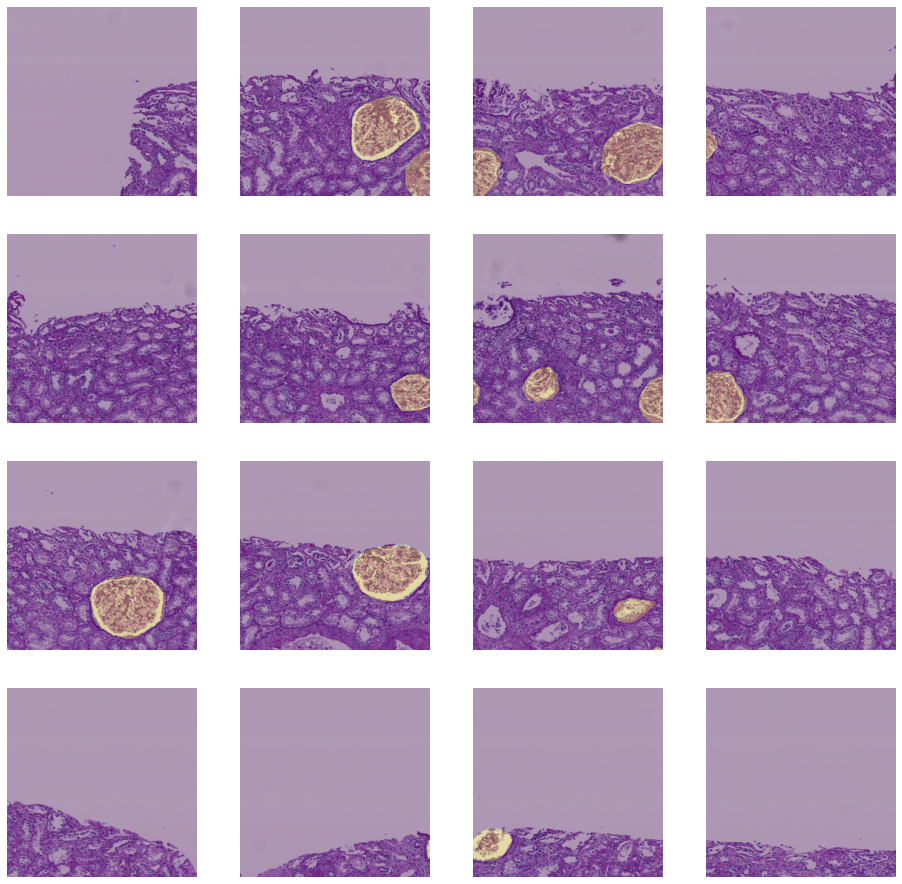

<IPython.core.display.Javascript object>

In [36]:
columns, rows = 4, 4
idx0 = 0
fig = plt.figure(figsize=(columns * 4, rows * 4))
with zipfile.ZipFile(OUT_TRAIN, "r") as img_arch, zipfile.ZipFile(
    OUT_MASKS, "r"
) as msk_arch:
    fnames = sorted(img_arch.namelist())  # [8:]
    for i in range(rows):
        for j in range(columns):
            idx = i + j * columns
            img = cv2.imdecode(
                np.frombuffer(img_arch.read(fnames[idx0 + idx]), np.uint8),
                cv2.IMREAD_COLOR,
            )
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            mask = cv2.imdecode(
                np.frombuffer(msk_arch.read(fnames[idx0 + idx]), np.uint8),
                cv2.IMREAD_GRAYSCALE,
            )

            fig.add_subplot(rows, columns, idx + 1)
            plt.axis("off")
            plt.imshow(Image.fromarray(img))
            plt.imshow(Image.fromarray(mask), alpha=0.3)
plt.show()

## Folds

In [37]:
from params import *

<IPython.core.display.Javascript object>

In [38]:
df_mask = pd.read_csv(DATA_PATH + "train.csv")

<IPython.core.display.Javascript object>

In [39]:
slide_ids = df_mask.id.unique().tolist()

with zipfile.ZipFile(OUT_TRAIN, "r") as img_arch, zipfile.ZipFile(
    OUT_TRAIN, "r"
) as msk_arch:
    fnames = img_arch.namelist()

df_images = pd.DataFrame()
df_images["tile_name"] = fnames
df_images["fold"] = df_images["tile_name"].apply(
    lambda f: slide_ids.index(f.split("_", 1)[0])
)

df_images["5fold"] = df_images["fold"].apply(lambda x: x % 5)

<IPython.core.display.Javascript object>

In [41]:
df_images.to_csv(OUT_PATH + "df_images.csv", index=False)

<IPython.core.display.Javascript object>